In [3]:
import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

import matplotlib.pyplot as plt
import re
import pandas as pd
from pathlib import Path
import torch
from fastai import get_image_files

from fastprogress import master_bar, progress_bar
%config InlineBackend.figure_format ='retina'

In [38]:
COMP_DATA_DIR = Path('.')

df = pd.DataFrame({'Image' : sorted(get_image_files(COMP_DATA_DIR / 'index', recurse=True))})
df.head()

Image
0  index/0/0/0/0000215a37942b17.jpg
1  index/0/0/0/00005baad2e46555.jpg
2  index/0/0/0/00007d3b7f15b575.jpg
3  index/0/0/0/00009069e8450638.jpg
4  index/0/0/0/00009574f46e9fd8.jpg

In [39]:
qdf = pd.DataFrame({'Image' : sorted(get_image_files(COMP_DATA_DIR / 'test', recurse=True))})
qdf.head()

Image
0  test/0/0/0/00016575233bc956.jpg
1  test/0/0/0/0001aadbcd8cb923.jpg
2  test/0/0/0/0002c06b2440a5f9.jpg
3  test/0/0/0/0002eb1ee5a5a6b2.jpg
4  test/0/0/0/000594dad986513e.jpg

In [40]:
query_fnames = [x.stem for x in qdf.Image.tolist()]
index_fnames = [x.stem for x in df.Image.tolist()]

In [41]:
!ls *npy

dist_densenet169_256_cut-extractor-2scales6patches-gem3.pth.npy
dist_densenet201_256_cut-extractor-2scales6patches-gem3.pth.npy
dist_resnet152_i200_l1000-256_256_cut-extractor-2scales6patches-gem3.pth.npy
dist_resnext101_32x8d_256_cut-extractor-2scales6patches-gem3.pth.npy
idx_densenet169_256_cut-extractor-2scales6patches-gem3.pth.npy
idx_densenet201_256_cut-extractor-2scales6patches-gem3.pth.npy
idx_resnet152_i200_l1000-256_256_cut-extractor-2scales6patches-gem3.pth.npy
idx_resnext101_32x8d_256_cut-extractor-2scales6patches-gem3.pth.npy


In [42]:
ensemble_archs = ['resnet152_i200_l1000-256', 'densenet169', 'densenet201', 'resnext101_32x8d']
npys = [f'{a}_256_cut-extractor-2scales6patches-gem3.pth.npy' for a in ensemble_archs]
idxs = [np.load(f'idx_{npy}') for npy in npys]
dsts = [np.load(f'dist_{npy}') for npy in npys]

In [52]:
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('test.csv')
sample_df['images'] = ''

l = len(index_fnames)
d  = np.empty(l, dtype=np.float32)
di = np.empty(l*2, dtype=np.float32)
sub = {}
for i, query_fname in progress_bar(enumerate(query_fnames), total=len(query_fnames)):
    d[:] = 0.
    for m in range(len(ensemble_archs)):
        for j in [i*2]:#, i*2+1]:
            dst,idx = dsts[m][j], idxs[m][j]
            di[:] = dst.max() * 10
            di[idx] = dst
            d += np.amin(di.reshape(-1,2), axis=-1) 
    ids = [index_fnames[x] for x in d.argsort()[:100]]
    sub[query_fname] = ' '.join(ids)

In [53]:
sub_fname = 'test_submission.csv'
sample_df = pd.read_csv('test.csv')
sample_df['images'] = ''

In [54]:
sub_df = pd.DataFrame({'id' : list(sub.keys()), 'images':list(sub.values())})
sub_df = pd.concat([sub_df, sample_df]).drop_duplicates(subset=['id'])
sub_df.to_csv(sub_fname, index=False)

In [55]:
sub_df.iloc[:10]

id                                             images
0  00016575233bc956  4c735b4557cb47fc a0047e7c5a974315 d04aa490f83c...
1  0001aadbcd8cb923  54f240e649f4ef18 041cdcddab926d9d b316bf4a7c52...
2  0002c06b2440a5f9  c5fcd16506f93e07 01f8834279b8a63d 21a8ee21f78a...
3  0002eb1ee5a5a6b2  f313947c38fa3296 db70274b4eab635b 8617db014754...
4  000594dad986513e  c873bdf0c5a2be11 11f251a61b5d3b90 d889a45d7239...
5  0006b7eb42bc7ee2  2c78d265870173d4 0923c4ac116ce75c c9c31b63b7a4...
6  00084cdf8f600d00  5370c4535b88ac27 1c6ec8308deaa065 bd1656c26b07...
7  0008722c48c52fda  fe0dcfcb54d45319 af6a2cedb474bc18 6a598a349934...
8  00090b69457cfbd3  d4f6343da861eba3 23af0cae870a2aa4 2dd3ff91c984...
9  0009ffd36a94a88f  8a16a5ae15a2559c e05cdbfebda1c2ae 6ddaaeb51a0b...

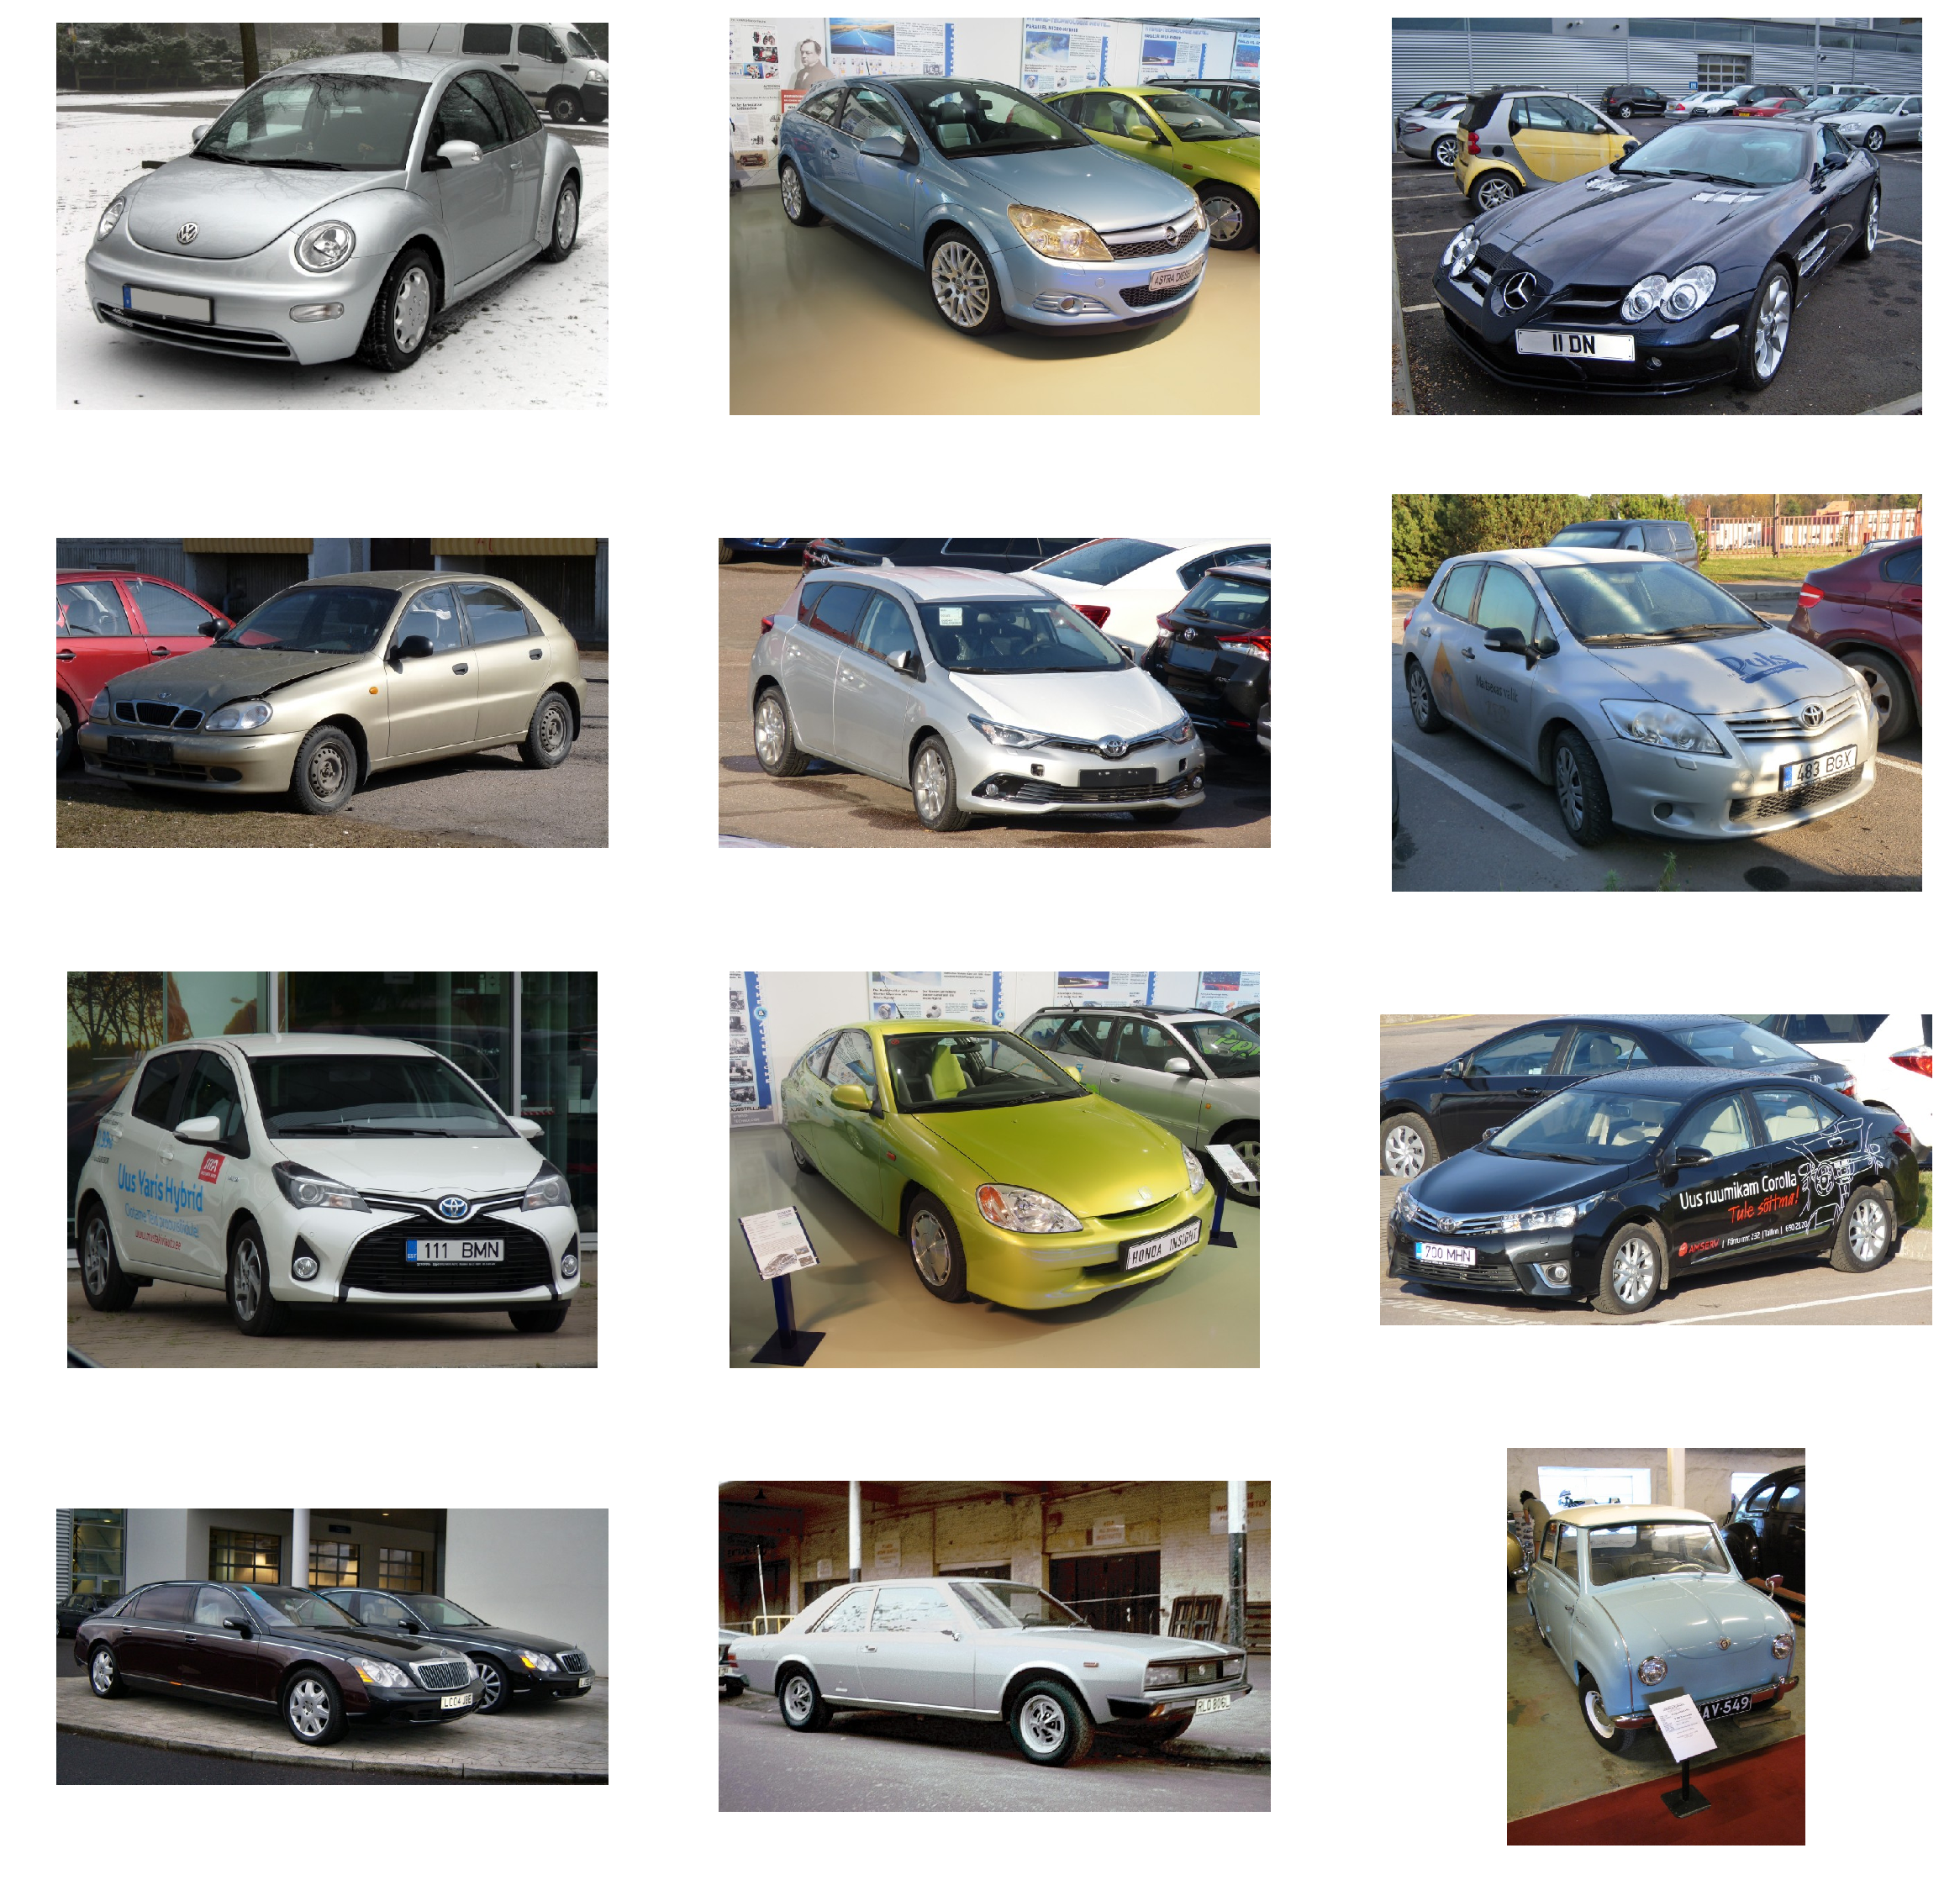

In [50]:
def fix_path(p):
    fn = str(p.name)
    return p.parent / fn[0] / fn[1] / fn[2] / fn
def image_results(row, n= 12):
    r = [open_image(fix_path(Path('test') / (row.id + '.jpg')))]
    r.extend([open_image(fix_path(Path('index') / (id + '.jpg'))) for id in row.images.split(' ')[:n]])
    return r
show_all(image_results(sub_df.iloc[3]),r=4,figsize=(20, 20))

In [57]:
!kaggle competitions submit -c landmark-retrieval-2019 -f {sub_fname} -m '{' '.join(ensemble_archs)}'

100%|████████████████████████████████████████| 193M/193M [00:07<00:00, 26.4MB/s]
Successfully submitted to Google Landmark Retrieval 2019

In [58]:
import time
time.sleep(10)

In [59]:
!kaggle competitions submissions -c landmark-retrieval-2019 -v > submissions.csv

In [60]:
submissions = pd.read_csv('submissions.csv')
submissions.iloc[0].publicScore

'0.08284'